In [14]:
%reload coax
import coax
env = gym.make('CartPole-v0')

print(coax.DynamicsModel.example_data(env.observation_space, env.action_space).type1)
print()
print(coax.DynamicsModel.example_data(env.observation_space, env.action_space).type2)
print()
# print(coax.Policy.example_data(env.observation_space, env.action_space))
# print()
# print(coax.Q.example_data(env.observation_space, env.action_space).type1)
# print(coax.Q.example_data(env.observation_space, env.action_space).type2)
# print()
# print(coax.V.example_data(env.observation_space))


ExampleData(
  inputs=Inputs(
    args=ArgsType1(
      S=array(shape=(1, 4), dtype=float32)
      A=array(shape=(1, 2), dtype=float32)
      is_training=True)
    static_argnums=(2,))
  output={
    'logvar': array(shape=(1, 4), dtype=float32)
    'mu': array(shape=(1, 4), dtype=float32)})

ExampleData(
  inputs=Inputs(
    args=ArgsType2(
      S=array(shape=(1, 4), dtype=float32)
      is_training=True)
    static_argnums=(1,))
  output={
    'logvar': array(shape=(1, 2, 4), dtype=float32)
    'mu': array(shape=(1, 2, 4), dtype=float32)})



/home/kris/git_tree/coax/coax/utils/_array.py:519: RuntimeWarning: overflow encountered in subtract
  sizes = onp.clip(space.high - space.low, 0, 100)


[  1.31489027  11.16517533   0.36651658 -12.74421043]
[  1.326839   11.147123    0.3656906 -12.744011 ]
[array([  1.3207107,  11.142469 ,   0.3662266, -12.7462225], dtype=float32), array([  1.306798 ,  11.128199 ,   0.3669182, -12.750051 ], dtype=float32)]


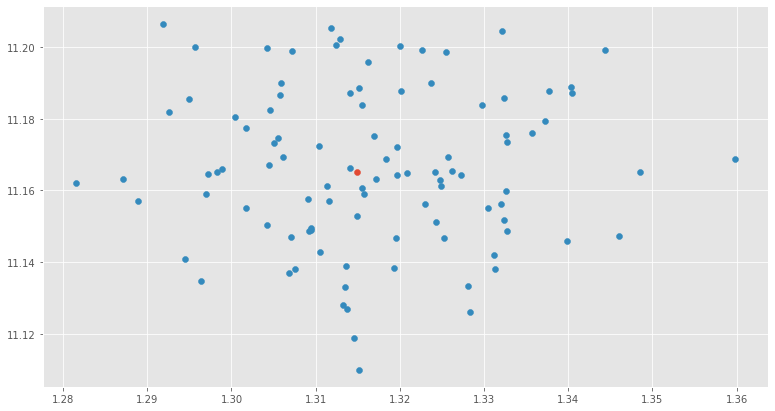

In [20]:


def check_onehot(S):
    if jnp.issubdtype(S.dtype, jnp.integer):
        return hk.one_hot(S, discrete.n)
    return S


def func_type1(S, A, is_training):
    # output shape
    output_shape = env.observation_space.shape
    batch_norm = hk.BatchNorm(False, False, 0.99)
    seq = hk.Sequential((
        hk.Flatten(),
        hk.Linear(8), jax.nn.relu,
        partial(hk.dropout, hk.next_rng_key(), 0.25 if is_training else 0.),
        partial(batch_norm, is_training=is_training),
        hk.Linear(8), jnp.tanh,
        hk.Linear(onp.prod(output_shape), w_init=jnp.zeros),
        hk.Reshape(output_shape),
    ))
    S = check_onehot(S)
    X = jax.vmap(jnp.kron)(S, A)
    mu = S + seq(X)
    return {'mu': mu, 'logvar': jnp.full_like(mu, -10)}


def func_type2(S, is_training):
    # output shape
    output_shape = (env.action_space.n, *env.observation_space.shape)
    batch_norm = hk.BatchNorm(False, False, 0.99)
    seq = hk.Sequential((
        hk.Flatten(),
        hk.Linear(8), jax.nn.relu,
        partial(hk.dropout, hk.next_rng_key(), 0.25 if is_training else 0.),
        partial(batch_norm, is_training=is_training),
        hk.Linear(8), jnp.tanh,
        hk.Linear(onp.prod(output_shape), w_init=jnp.zeros),
        hk.Reshape(output_shape),
    ))
    S = check_onehot(S)
    mu = S + seq(S)
    return {'mu': mu, 'logvar': jnp.full_like(mu, -10)}


p1 = coax.DynamicsModel(func_type1, env.observation_space, env.action_space)
p2 = coax.DynamicsModel(func_type2, env.observation_space, env.action_space)

s = coax.safe_sample(env.observation_space)
a = env.action_space.sample()


print(s)
xs, ys = jnp.stack([p2(s, a)[:2] for _ in range(100)]).T
plt.scatter(s[0:1], s[1:2])
plt.scatter(xs, ys)

print(p2(s, a))  # [0.4924, 0.4847, 0.4188, 0.8796]
print(p2(s))     # array([0., 0.])

In [12]:
def p(s):
    return s * 13

p(s, a)

TypeError: p() takes 1 positional argument but 2 were given

In [44]:
proba_dist = coax.proba_dists.ProbaDist(env.observation_space)
jnp.concatenate([proba_dist.preprocess_variate(s)] * 3).shape

(3, 4)

[0.86147307 0.95634397 0.16891363 0.32490073]
[1.9287863  6.713625   0.03634137 2.3091335 ]
[1.9316001  6.714117   0.03567713 2.4450932 ]
[1.972897  6.6620464 0.034614  2.329832 ]
[1.9657674  6.7128773  0.03661525 2.3622189 ]
[1.9446254  6.6932793  0.03715074 2.4681492 ]
[1.9456129 6.6337357 0.0360142 2.3984776]
[1.940661   6.6858845  0.03601834 2.5070992 ]
[1.9558325  6.6058197  0.03518942 2.368702  ]
[1.9295654  6.7178383  0.03541228 2.401804  ]
[1.963522   6.6830616  0.03230423 2.3312092 ]


In [13]:
from typing import NamedTuple, Any, Tuple


class PrettyReprMixin:
    def __repr__(self):
        return _repr(self)


def _repr(o, d=0):
    assert False, type(o)
    i = "  "  # indentation string
    if isinstance(o, (jnp.ndarray, onp.ndarray)):
        return f"array(shape={o.shape}, dtype={str(o.dtype)})"
    if hasattr(o, '_asdict'):
        sep = '\n' + i * (d + 1)
        body = sep + sep.join(f"{k}={_repr(v, d + 1)}" for k, v in o._asdict().items())
        return f"{type(o).__name__}({body})"
    if isinstance(o, Mapping):
        sep = '\n' + i * (d + 1)
        body = sep.join(f"'{k}': {_repr(v, d + 1)}" for k, v in o.items())
        return f"{{{body}}}"
    return repr(o)


class Inputs(PrettyReprMixin, NamedTuple):
    args: Any
    static_argnums: Tuple[int, ...]
        


data = Inputs(args={'a': 13, 'b': 11}, static_argnums=7)
data

Inputs(args={'a': 13, 'b': 11}, static_argnums=7)

In [3]:
coax._core.dynamics_model.ArgsType1(S=13, A=7, is_training=True)

TypeError: __new__() got an unexpected keyword argument 'S'